In [1]:
import random
import math
import numpy as np
from random import randrange
import copy
import gymnasium as gym

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

def sign(num):
    return -1 if num < 0 else 1

In [2]:
#develop expression tree generator
###SIMPLIFY: DON'T NEED TO CALCULATE NUMBER, JUST BUILD LIST; though prob keep calculation to end tree building###
###fix min/max length and density###
###seed appears unused###
###make it easier to customize used functions###
###need to overhaul; could probably get away with tree dict instead of object, as most members of object are 
###global parameters
###cutoffs fo rmutations hard-coded

def grow(i, seed, tree):
    random.seed
#all grow will apply any function or leaf
#iteration variable i tracks depth of tree to ensure minimum or maximum depths
#seed is the current tree to be grown
#tree is an object with hyperparmeters min_depth, max_depth, number of sensors, constant range, sensor values array
   
#choose a random number to how tree will grow, operator or leaf (sensor or constant)
#if below min depth cannot be leaf, if at max depth must be leaf
    if i<tree.min_depth:
        key=random.randint(tree.num_sens+1, tree.num_sens+9-1)
    elif i>=tree.max_depth:
        key=random.randint(0, tree.num_sens+1-1)
    else: key=random.randint(0,tree.num_sens+9-1)
    #remove trig functions and log, comment to include
    #while key in range(tree.num_sens+2,tree.num_sens+6):  key=random.randint(0,tree.num_sens+9-1)
    #print(i, key, tree.name)
#if leaf, easy, just return the sensor value or a random constant [-10,10]
    if key in range (0,tree.num_sens):
        i-=1
        growth=tree.sens[key]
        s='s'+str(key)
        tree.name.append(s)
        #tree.name=tree.name+" s"+str(key)
        return growth
    if key==tree.num_sens:
        i-=1
        a=round(random.uniform(-10,10),3)
        tree.name.append(a)
        #tree.name=tree.name+" "+str(a)
        return a
#if function a bit harder, use function then call grow recursively
    if key==tree.num_sens+1:
        i+=1
        #tree.name+=" math.tanh"
        tree.name.append('math.tanh')
        growth=math.tanh(grow(i,seed,tree))
        return growth
    if key==tree.num_sens+2:
        i+=1
        tree.name.append('math.sin')
        #tree.name+=" math.sin"
        growth=math.sin(grow(i,seed,tree))
        return growth
    if key==tree.num_sens+3:
        i+=1
        tree.name.append('math.cos')
        #tree.name+=" math.cos"
        growth=math.cos(grow(i,seed,tree))
        return growth
    if key==tree.num_sens+4:
        i+=1
        #tree.name+=" math.log"
        tree.name.append('math.log')
        b=grow(i,seed,tree)
        #print(b)
        if abs(b)>=10**-3:
            growth=b/abs(b)*math.log(abs(b))
        if abs(b)<10**-3:
            growth=0
        return growth
    if key==tree.num_sens+5:
        i+=1
        tree.name.append('math.exp')
        #tree.name+=" math.exp"
        a=grow(i,seed,tree)
        #prevent float overflow; I seriously doubt e^10 will ever be the right answer
        if a>10:
            a=10
        growth=math.exp(a)
        return growth
#now the hard part, using the +,-,x,/ functions which split branch
#need to track total tree depth on each branch and add new branch
    if key==tree.num_sens+6:
        i+=1
        #tree.name+=" +"
        tree.name.append('+')
        growth=grow(i,seed, tree)+grow(i,seed,tree)
        return growth
    if key==tree.num_sens+7:
        i+=1
        tree.name.append('-')
        #tree.name+=" -"
        a=grow(i,seed,tree)
        b=grow(i,seed,tree)
        #avoid disappearing branches throwing off recursion and junk equation values
        if a==b:  b=b+0.01
        growth=a-b
        #growth=grow(i,seed,tree)-growth(i,seed,tree)
        return growth
    if key==tree.num_sens+8:
        i+=1
       # tree.name+=" *"
        tree.name.append('*')
        a=grow(i,seed, tree)
        b=grow(i,seed, tree)
        growth=a*b
        return growth
    if key==tree.num_sens+9:
        i+=1
        tree.name.append('/')
        a=grow(i,seed, tree)
        #tree.name+=" /"
        check1=len(tree.name)
        b=grow(i,seed, tree)
        check2=len(tree.name)
        #if check2 == check1:  print(tree.name)
        if abs(b)>10**-3:
            growth=a/b
        elif b==0:
            growth=a/10**-3
        elif abs(b)<=10**-3:
            growth=a/(np.sign(b)*10**-3)
        return growth

In [3]:
#develop expression tree generator--only polynomial and sinusodial
###fix min/max length and density###
###seed appears unused###
###make it easier to customize used functions###
###need to overhaul; could probably get away with tree dict instead of object, as most members of object are 
###global parameters

def growTrig(i, seed, tree):
    random.seed
#all grow will apply any function or leaf
#iteration variable i tracks depth of tree to ensure minimum or maximum depths
#seed is the current tree to be grown
#tree is an object with hyperparmeters min_depth, max_depth, number of sensors, constant range, sensor values array
   
#choose a random number to how tree will grow, operator or leaf (sensor or constant)
#if below min depth cannot be leaf, if at max depth must be leaf
    if i<tree.min_depth:
        key=random.randint(tree.num_sens+1, tree.num_sens+6-1)
    elif i>=tree.max_depth:
        key=random.randint(0, tree.num_sens+1-1)
    else: key=random.randint(0,tree.num_sens+6-1)
    #remove trig functions and log, comment to include
    #while key in range(tree.num_sens+2,tree.num_sens+6):  key=random.randint(0,tree.num_sens+9-1)
    #print(i, key, tree.name)
#if leaf, easy, just return the sensor value or a random constant [-10,10]
    if key in range (0,tree.num_sens):
        i-=1
        growth=tree.sens[key]
        s='s'+str(key)
        tree.name.append(s)
        #tree.name=tree.name+" s"+str(key)
        return growth
    if key==tree.num_sens:
        i-=1
        a=round(random.uniform(-10,10),3)
        tree.name.append(a)
        #tree.name=tree.name+" "+str(a)
        return a
#if function a bit harder, use function then call grow recursively
    if key==tree.num_sens+1:
        i+=1
        #tree.name+=" math.tanh"
        tree.name.append('math.sin')
        growth=math.tanh(growTrig(i,seed,tree))
        return growth
    if key==tree.num_sens+2:
        i+=1
        tree.name.append('math.cos')
        #tree.name+=" math.sin"
        growth=math.sin(growTrig(i,seed,tree))
        return growth
#now the hard part, using the +,-,x,/ functions which split branch
#need to track total tree depth on each branch and add new branch
    if key==tree.num_sens+3:
        i+=1
        #tree.name+=" +"
        tree.name.append('+')
        growth=growTrig(i,seed, tree)+growTrig(i,seed,tree)
        return growth
    if key==tree.num_sens+4:
        i+=1
        tree.name.append('-')
        #tree.name+=" -"
        a=growTrig(i,seed,tree)
        b=growTrig(i,seed,tree)
        #avoid disappearing branches throwing off recursion and junk equation values
        if a==b:  b=b+0.01
        growth=a-b
        #growth=grow(i,seed,tree)-growth(i,seed,tree)
        return growth
    if key==tree.num_sens+5:
        i+=1
       # tree.name+=" *"
        tree.name.append('*')
        a=growTrig(i,seed, tree)
        b=growTrig(i,seed, tree)
        growth=a*b
        return growth
    if key==tree.num_sens+6:
        i+=1
        tree.name.append('/')
        a=growTrig(i,seed, tree)
        #tree.name+=" /"
        check1=len(tree.name)
        b=growTrig(i,seed, tree)
        check2=len(tree.name)
        #if check2 == check1:  print(tree.name)
        if abs(b)>10**-3:
            growth=a/b
        elif b==0:
            growth=a/10**-3
        elif abs(b)<=10**-3:
            growth=a/(np.sign(b)*10**-3)
        return growth

In [4]:
#Evaluate tree at value

def evaluate(token ):

    #evaluate takes a set of sensor mesaruments (array of size tree.num_sens).  Sensors values are seperate from tree.sens
#this is basically opposite of tree building
#evaluate must be called from total evaluate to replace the sensor with appropriate values

    token=copy.copy(token) #this took awhile to figure out
    t=token.pop(0)
#     print(t, token)
#     print(t,token)
#     print(type(t))
    if t=='+':
#         print(t, '+')
        a,token=evaluate(token)
        b,token=evaluate(token)
        #print(a,b)
        return a+b,token
    elif t=='-':
#         print(t,'-')
        a,token=evaluate(token)
        b,token=evaluate(token)
        if a==b:  b=b+0.01
        #print(a,b)
        return a-b,token
    elif t=='*':
#         print(t,'*')
        a,token=evaluate(token)
        b,token=evaluate(token)
        #print(a,b)
        return a*b, token
    elif t=='/':
#         print(t,'/')
        a,token=evaluate(token)
        b,token=evaluate(token) #protect against divide by 0
        if b==0:
            return a/10**-3, token
        elif abs(b)<10**-3:
            return a/(np.sign(b)*10**-3),token
        else:
            return a/b,token
    elif (isinstance(t,np.float64) or isinstance(t, float)):
        #print(t, 'float')
        return t, token
    #if it isn't one of the above, then it is a transcendental function and will be func(lower branch)
    else:
#         print(t)
        temp,token=evaluate(token)
#         print(temp,token)
        if t=='math.exp':
            if abs(temp)>50:
                temp=sign(temp)*50
        if t=='math.log':
            if abs(temp)>10**-3:
                temp=abs(temp)
            else:
                temp=10**-3
        a=t+'('+str(temp)+')'
#         print(t,a)
        return eval(a),token

In [5]:
#Define branches

def branch(n, tree):
#branch defines a branch from a tree, starting from point n in the tree, where n is an int 
#for an address in the list that defines the tree
#iterate through the list defining the tree starting at n until enough leafs have been encountered to define the branch
#need one leaf plus one extra leaf per operand (+, -, *, /).  Leaf is sensor or constant
#to make easier, change all sensors to a float locally in the function
#function returns index for the end of the branch
    tree=copy.copy(tree)
    op_list =['+', '-', '*', '/']
    c=1 #leaf counter
    while c>0:
        if n>=len(tree.name):  print('branch fail', n, tree.name)
        if type(tree.name[n])==float:
            c-=1
            #print(tree.name[n], c, 'loss')
        elif tree.name[n].startswith('s'):
            c-=1
            #print(tree.name[n], c, 'loss')
        for x in op_list:
            if tree.name[n] == x:
                c+=1
                #print(tree.name[n], c, 'gain')
        n+=1
    return n

In [6]:
#evolution functions
#mutation will consist of four types:  cut and grow, shrink, hoist, re-paramaterize

#cut and grow:  replace aribrary subbranch with a new branch
#dtermien branch to be removed using branch, parse tree into 3 parts:  left of cut, cut section, right of cut
#replace cut section with new branch
###Clean up to better preserve min/max lengths and density when substituting branches###
def cutgrow(x):
    tree=copy.copy(x)
    random.seed
    cut=randrange(len(tree.name))
    end=branch(cut,tree)
    #print(cut, end)
    if cut>0:
        keepLeft=tree.name[0:cut]
    else:  keepLeft=[]
    if end<len(tree.name):
        keepRight=tree.name[end:len(tree.name)]
    else:  keepRight=[]
    dummy=sapling(tree.min_depth, tree.max_depth-1, tree.num_sens) 
    #need to pass a sapling object to grow a branch, so make a dummy one to grow
    #reduce depth by one to make new sub branch a little cleaner
    total=grow(0,2,dummy)
    #print("old:")
    #print(tree.name[cut:end])
    #print("new:")
    #print(dummy.name)
    new_name=keepLeft
    new_name+= dummy.name
    new_name+=keepRight
    #print(new_name)
    return new_name
    
#shrink replaces tree with randomly chosen leaf.  For now, make it a new random leaf (sensor or constant)
def shrink(x):
    tree=copy.copy(x)
    cut=randrange(len(tree.name))
    end=branch(cut, tree)
    #print(cut, end)
    if cut>0:
        keepLeft=tree.name[0:cut]
    else:  keepLeft=[]
    if end<len(tree.name):
        keepRight=tree.name[end:len(tree.name)]
    else:  keepRight=[]
    key=random.randint(0,tree.num_sens)
    new_name=keepLeft
    if key in range (0,tree.num_sens):
        s='s'+str(key)
        new_name.append(s)
    if key==tree.num_sens:
        a=round(random.uniform(-10,10),3)
        new_name.append(a)   
    new_name+=keepRight
    #print(new_name)
    return new_name

#hoist replaces tree by random subtree
def hoist(x):
    tree=copy.copy(x)
    cut=randrange(len(tree.name))
    end=branch(cut, tree)
    new_name=tree.name[cut:end]
    #print(new_name, cut, end)
    return new_name

#reparmaterize replaces each constant with random different constant
#this is the only one that directly changes tree
def reparam(x):
    tree=copy.copy(x)
    for i in range(len(tree.name)):
        if type(tree.name[i])==float:
            tree.name[i]=round(random.uniform(-10,10),3)
    return tree.name

#crossover swaps subtrees between trees
def cross(x1, x2):
    tree1=copy.copy(x1)
    if len(tree1.name)== 0:  print('cross tree1 empty')
    tree2=copy.copy(x2) 
    cut1=randrange(len(tree1.name))
    if len(tree1.name)<=cut1:  print('cross 1 short', len(tree1.name), cut1)
    end1=branch(cut1, tree1)
    if cut1>0:
        keepLeft1=tree1.name[0:cut1]
    else:  keepLeft1=[]
    if end1<len(tree1.name):
        keepRight1=tree1.name[end1:len(tree1.name)]
    else:  keepRight1=[]
    swap1=tree1.name[cut1:end1]
    #print("swap1")
    #print(swap1)
    cut2=randrange(len(tree2.name))
    if len(tree2.name)== 0:  print('cross tree2 empty')
    if len(tree2.name)<=cut2:  print('cross 2 short', len(tree2.name), cut)
    end2=branch(cut2, tree2)
    if cut2>0:
        keepLeft2=tree2.name[0:cut2]
    else:  keepLeft2=[]
    if end2<len(tree2.name):
        keepRight2=tree2.name[end2:len(tree2.name)]
    else:  keepRight2=[]
    swap2=tree2.name[cut2:end2]
    #print("swap2")
    #print(swap2)
    new_name1=keepLeft1
    new_name1+=swap2
    new_name1+=keepRight1
    
    new_name2=keepLeft2
    new_name2+=swap1
    new_name2+=keepRight2
    
    return new_name1, new_name2    

In [7]:
#set evoluation approach
#determine what and how many of previous generation trees to use to make next generation
#determine what to do do trees (replicate, mutate, cross) for next generation
#determine if to add whole new members to populations

#Need to calculate cost function for each individual for all snesors through time period
def total_evaluate(b,s,tree):
#s is a 2d array of sensor values across all sensors and all time/space
#b is 1d list of target values across time
#pass all sensors one time step at a time to evaluate tree value at each time step
#each sensor is a row, each timestep a column
    J=0.
    tree=copy.copy(tree)
    for i in range(len(b)):
        dummy=copy.copy(tree)
        if tree.num_sens>1:
            for j in range(tree.num_sens):
                sensor="s"+str(j)
                dummy.name=[s[j,i] if t==sensor else t for t in dummy.name]
                if len(dummy.name)==0: print("total nsens empty")
        else:
            dummy.name=[s[i] if t=='s0' else t for t in tree.name]
            if len(dummy.name)==0: print("total 1sens empty")
        step,dummy=evaluate(dummy.name)
#         print(tree.name, 'top')
#         print(dummy, 'next')
#         if s.ndim==1:
#             step,dummy=evaluate([s[i]], tree.name, tree.num_sens)
#         else:
#             step,dummy=evaluate(s[:,i], tree.name, tree.num_sens)
        #J+=cost(len(b), b[i], step)
        J+=1/len(b)*(b[i]-step)**2
        #print(J, b[i], s[i], step)
    return J

#define the cost function
def cost(scale, target, current):
#scale is the scaling factor for averaging cost at each step, target is desired value, current is function value
    return (target-current)**2/scale
    
def cost_extract(tree):
    return tree.total


In [8]:
#choose individuals for next round based on parameters
def selection(Ni, Np, forest):
    new_forest=[] #next generation
    random.seed
    while len(new_forest)<Ni:
        choices=random.sample(range(0,Ni), Np)
        pool=[] #holds local pool
        pool_value=[] #holds cost score for each tree in pool
        for c in choices:
            pool.append(forest[c])
            pool_value.append(forest[c].total)
        #only take 1 minimum value from each
        winner=np.where(pool_value==np.min(pool_value))[0][0]
        new_forest.append(pool[winner])
    return new_forest

In [9]:
#evolve next population using tournmanet as in Duriez, Brunton, Novak
def evolution(Ne, Pc, Pm, new_forest):
    #print(type(new_forest))
    #print(type(new_forest[0]))
#     for t in new_forest:
#         print('presort ',t.name, t.total)
    new_forest.sort(key=cost_extract) #rank by ascending cost to identify elites
#     for t in new_forest:
#         print('sort ',t.name, t.total)
    copy = new_forest[Ne:]
    random.shuffle(copy)
    new_forest[Ne:]= copy #shuffle rest of list
    breeders=[]
    for t in range(Ne,len(new_forest)):
        if len(new_forest[t].name)==0:  print("evo empty", t, new_forest[t].name, new_forest[t-1].name, new_forest[t+1].name, last_roll)
        random.seed
        roll=random.uniform(0,1)
        #print('roll ',roll)
        if roll<=Pc:
            breeders.append(t)
            if len(breeders)>1: #cross breed each pair as they are selected
                #print(new_forest[breeders[0]].name,new_forest[breeders[1]].name)
                if len(new_forest[breeders[0]].name)==0:  print('breeder 0 empty', breeders[0])
                if len(new_forest[breeders[1]].name)==0:  print('breeder 1 empty', breeders[1])
                new_forest[breeders[0]].name,new_forest[breeders[1]].name = \
                cross(new_forest[breeders[0]],new_forest[breeders[1]])
                #print(new_forest[breeders[0]].name,new_forest[breeders[1]].name)
                breeders=[]
        if (roll>Pc and roll <Pc+Pm):
            if roll<0.75:
                #print(new_forest[t].name)
                new_forest[t].name==cutgrow(new_forest[t]) #take out cutgrow for troubleshooting
                #print(new_forest[t].name, 'cutgrow')
            elif roll<0.80:
                #print(new_forest[t].name)
                new_forest[t].name=shrink(new_forest[t]) #take out shirnk for troubleshooting
                #print(new_forest[t].name, 'shrink')
            elif roll<0.85:
                #print(new_forest[t].name)
                new_forest[t].name=hoist(new_forest[t])
                #print(new_forest[t].name, 'hoist')
            else:
                new_forest[t].name=reparam(new_forest[t])
        last_roll=roll
    return new_forest

In [10]:
#evolve next population--with random reseeding of part of the population
def evolution_reseed(Nn, Ni, Ne, Pc, Pm, forest):
    #print(type(new_forest))
    #print(type(new_forest[0]))
    forest.sort(key=cost_extract) #rank by ascending cost to identify elites
    #shennanigans to include elites in mutation popoulation and get around Python's way of handling memory and lists
    elites=[]
    for i in range(0,Ne):
        elites.append(sapling(forest[0].min_depth, forest[0].max_depth, forest[0].num_sens))
        elites[i].name=forest[i].name.copy()
    #shuffle after elites to avoid cross breeding similar trees    
    copy = list(forest[Ne:int((1-Nn)*Ni)])
    random.shuffle(copy)
    
    new_forest=list(forest)
    new_forest[Ne:int((1-Nn)*Ni)]= copy.copy() #shuffle top half of list
    new_forest[Ne:Ne+Ne]=list(elites) #put elites into breeding pool

    breeders=[]
    checkname=new_forest[0].name
    for t in range(Ne,int((1-Nn)*Ni)): #
        random.seed
        roll=random.uniform(0,1)
        #print('roll ',roll)
        if roll<=Pc:
            breeders.append(t)
            if len(breeders)>1: #cross breed each pair as they are selected
                #print(new_forest[breeders[0]].name,new_forest[breeders[1]].name)
                new_forest[breeders[0]].name,new_forest[breeders[1]].name = \
                cross(new_forest[breeders[0]],new_forest[breeders[1]])
                #print(new_forest[breeders[0]].name,new_forest[breeders[1]].name)
                breeders=[]
        if (roll>Pc and roll <Pc+Pm):
            if roll<0.68:
                #print(new_forest[t].name)
                new_forest[t].name==cutgrow(new_forest[t]) #take out cutgrow for troubleshooting
                #print(new_forest[t].name, 'cutgrow')
            elif roll<0.75:
                #print(new_forest[t].name)
                new_forest[t].name=shrink(new_forest[t]) #take out shirnk for troubleshooting
                #print(new_forest[t].name, 'shrink')
            elif roll<0.83:
                #print(new_forest[t].name)
                new_forest[t].name=hoist(new_forest[t])
                #print(new_forest[t].name, 'hoist')
            else:
                new_forest[t].name=reparam(new_forest[t])
        #if evolution results in constant, replace with random new tree
        # py_list = new_forest[t].name.copy()
        # py_list=[str(r) for r in py_list]
        # r = [s for s in py_list if "s" in s]
        # while len(r)==0:
        #     new_forest[t].name=[]
        #     dummy=growTrig(0,2,new_forest[t])
        #     py_list = new_forest[t].name.copy()
        #     py_list=[str(r) for r in py_list]
        #     r = [s for s in py_list if "s" in s]
        #end replacement, not implemented in evolution function
    for t in range(int((1-Nn)*Ni),Ni):
            new_forest[t].name=[]
            dummy=grow(0,2,new_forest[t])
        #if constant, replace tree with random new tree
            # py_list = new_forest[t].name.copy()
            # py_list=[str(r) for r in py_list]
            # r = [s for s in py_list if "s" in s]
            # while len(r)==0:
            #     new_forest[t].name=[]
            #     dummy=growTrig(0,2,new_forest[t])
            #     py_list = new_forest[t].name.copy()
            #     py_list=[str(r) for r in py_list]
            #     r = [s for s in py_list if "s" in s]
        #end replacement of constant trees
    return new_forest

In [11]:
class sapling:
    def __init__(self,mind,maxd,num):
        self.min_depth=mind
        self.max_depth=maxd
        self.num_sens=num
        self.total=[]
        self.sens=[] #for now this is dummy numbers to make tree builder work properly
        self.name=[]
        for x in range(num):
            self.sens.append(0.5)

In [25]:
tree=sapling(3,5,1)
trial=growTrig(0,2,tree)
print(tree.name)
print(trial)
#print(evaluate(tree.sens,tree.name))
tree1=sapling(3,4,1)
trial1=grow(0,2,tree1)
print(tree1.name)

['-', '-', 'math.cos', '+', 'math.sin', 's0', '+', -1.947, 's0', '*', 'math.cos', -5.549, '*', 0.284, 'math.cos', -8.02, 'math.cos', 'math.sin', 'math.cos', 'math.sin', 's0']
-1.0519177343053605
['*', '-', 'math.log', 'math.sin', -9.586, '+', '*', -3.651, 2.872, '*', 9.388, 's0', '-', 'math.tanh', '*', 's0', -6.944, '-', 's0', 'math.sin', 's0']


In [22]:
print(cutgrow(tree))
print(shrink(tree))
print(hoist(tree))
print(reparam(tree))
print(cross(tree1,tree))

['math.exp', 'math.exp', 'math.sin', 'math.log', 'math.exp', 's0']
['math.exp', 'math.log', 's0']
[3.632]
['math.exp', 'math.log', 'math.log', 6.493]
(['math.cos', '-', 'math.cos', 'math.cos', 8.663, '-', '-', 's0', 's0', 'math.log', 'math.exp', 'math.log', 'math.log', 6.493], ['s0'])


tree1=sapling(2,4,1)
tree2=sapling(2,4,1)
tree3=sapling(2,4,1)
trial=grow(0,2,tree1)
trial=grow(0,2,tree2)
trial=grow(0,2,tree3)
print(tree1.name)
print(tree2.name)
a,b=cross(tree1, tree2)
print(a)
print(b)

In [ ]:
#try GP against 2.3.1 in Duriez/Brunton/Noack
#find match for 201 point plane defined by si=i/10, bi=tanh(1.256*si)+1.2; i=[-100,100]
#J = 1/201 sigma (bi-K(si))**2

Ni=1000 #number of individuals
Np=3 #idnvidiuals selected for advancement tournament each round
Ne=10  #best Ne of each forest advanced unchanged
Nn=0.3 #for reseed, precent reseeded each round

Pr=0.1 #probably of replication
Pm=0.2 #probably of mutation
Pc=0.7 #probably of crossover

maxi=50 #set max number of iterations

s=np.array(range(-100,101))
s=s/10.
#s=[i/10 for i in s if i>-200]
#b=[math.tanh(1.256*i)+math.sin(2.0*i) for i in s if i>-20]
b=[math.tanh(1.256*i) for i in s if i>-20]

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,7,1)
    trial=grow(0,2,seed)
    forest.append(seed)

minJ=1000 #set "best" cost
i=0 #iteration counter

forest[0].name=['math.tanh', '*', 1.25, 's0']

while (minJ>10**-6 and i<50):
    for t in forest:
        #determine cost function
        #iterate through a list of trees and store best
        t.total=total_evaluate(b,s,t)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
#     next_forest=selection(Ni, Np, forest)
#     for t in next_forest:
#         if len(t.name)==0: print("selection empty")
#         if type(t.name)==bool:  print("selection bool")
#     #Np individuals will be ranked and the best will advance to replication, mutation, crossover
#     forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    i+=1
    print(i, minJ, bestTree)

print(minJ, bestTree)



In [ ]:
#2.3.2 in Duriez Brunton Noack ,using scipy.integrate.solve_ivp
#solve da/dt=a+b. s=a. b=K(s), minimize 1/T int(a882+g*b**2 dt)
#will need to implement ODE solver and Cost function

Ni=50 #number of individuals
Np=7 #idnvidiuals selected for advancement tournament each round
Ne=1  #best Ne of each forest advanced unchanged
Nn=0.3 #percent new reseeds for evo_reseed

Pr=0.1 #probably of replication
Pm=0.4 #probably of mutation
Pc=0.5 #probably of crossover

g=1.0 #penalization coefficient for acutation cos-t

maxi=50 #set max number of iterations

def dynamics(t, a, control):
#handle plant dynamics, this needs extensive manual modification for each different plant
#have to change dynamcis, and control calculation
    #catch unstable forcing or system to prevent float overflow; may need to adjust catch values for different systems
    if a[0]>100:  a[0]=100
    elif a[0]<-100:  a[0]=-100 #cap divergent solt'n/unstable controllers from reaching inf/nan
    control=[a[0] if c=='s0' else c for c in control]
    K,dummy=evaluate(control)
    da=a+K
    return da

s=np.arange(0,10,0.025)
s_span=(0,10)
T=s[len(s)-1]-s[0]
dt=s[1]-s[0]

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,5,1)
    trial=grow(0,2,seed)
    forest.append(seed)

minJ=1000 #set "best" cost
j=0 #iteration counter

forest[0].name=['*', '*', 3.128, 's0', 'math.tanh', 'math.tanh', -6.613]

while (minJ>10**-4 and j<30):
    for t in forest:
        #determine cost function
        #iterate through a list of trees and store best
        #to determine cost, need a and b for every timestep
        #solve returns a t length array of a values
        #need to evaluate b at each step for dynamics and cost function
        #probably should use evaluate function on its own and avoid total_evaluate
        control_name=t.name
        b=[]
        result=solve_ivp(dynamics, s_span, [1], t_eval=s, args=[control_name])
        result.y=np.reshape(result.y, (result.y.size,))
        for i in range(len(result.y)):
            control_name=t.name
            control_name=[result.y[i] if c=='s0' else c for c in control_name]
            K,dummy=evaluate( control_name)
            b.append(K)
        t.total=1/T*sum(dt*(np.array(result.y)**2+g*np.array(b)**2))
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
#     next_forest=selection(Ni, Np, forest)
#     for t in next_forest:
#         if len(t.name)==0: print("selection empty")
#         if type(t.name)==bool:  print("selection bool")
#     #Np individuals will be ranked and the best will advance to replication, mutation, crossover
#     forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    j+=1
    print(j, minJ, bestTree)

print(minJ, bestTree)


In [ ]:
print(math.tanh(1.256*s[0,1])+math.cos(s[1,1]))
print(math.tanh(1.256*s[0,10])+math.cos(s[1,10]))
print(math.tanh(1.256*s[0,100])+math.cos(s[1,100]))

In [12]:
#integrate MLC with gymanisum
import gymnasium as gym
env = gym.make("VDP")
observation, info = env.reset(seed=42)
observation1, info1 = env.reset(seed=42)
print(observation1-observation)
a = list(env.observation_space.shape)
print("obs space:  ", len(observation), observation.shape)
print("action space:  ", env.action_space.low.item(), env.action_space.high.item())
for _ in range(3):
    action = env.action_space.sample()  # this is where you would insert your policy
    print("action:  ", action) 
    observation, reward, terminated, truncated, info = env.step(action)
    print("obs:  ", observation)
    print("reward:  ", reward)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

[-0.34885841  4.5035525 ]
obs space:   2 (2,)
action space:   -2.0 2.0
action:   [1.96722708]
obs:   [ 6.13615638 -0.9601806 ]
reward:   -6.210826181077578
action:   [1.02195725]
obs:   [ 6.1351962  -0.81225073]
reward:   -6.1887303714365665
action:   [1.12137409]
obs:   [ 6.13438394 -0.68594864]
reward:   -6.172616294564139


C:\Users\robert\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:521: UserWarning: WARN: Using the latest versioned environment `VDP-v1` instead of the unversioned environment `VDP`.
  logger.warn(


In [ ]:
env = gym.make("Pendulum-v1")
observation, info = env.reset(seed=42)
#####notes on using gymnasium######
#need size of observation space for number of states
#need size of action space for number of MLC equations and limits to cap action
# use list(env.observation_space.shape)[0] for size of obs, action spaces
#use env.action_space.low(high).item() for action space min, max

#use MLC for inverted double pendulum gymnasium per:  https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/
#generalize for any observation space size

Ni=800 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=3  #best Ne of each forest advanced unchanged
n_batches=5  #number of times to run through the environment with different seeds 
            #per tree per iteration to avoid lucky starts
min_TreeSize=2
max_TreeSize=5

Ns=list(env.observation_space.shape)[0] #number of sensors
maxi=1505 #set max number of iterations

#need to get initial measurements from observation, fortunately already is a numpy array (!)
s=observation
b=0 #dummy initialization of b

#will need to refactor for "online" programming, rather than having all measurments avilable at once

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(min_TreeSize,max_TreeSize,Ns)
    trial=growTrig(0,2,seed)
    forest.append(seed)

maxJ=-50000 #set initial "best" cost
k=0 #iteration counter

while (maxJ<-1.0 and k<maxi):
    #make random starting point each forest generation, but same for each tree per generation, different for each batch
    randSeeds=random.sample(range(10000),n_batches)#random.randint(0,10000)
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        t.total=0
        for n in randSeeds:
            observation, info = env.reset(seed=n)
            #iterate through a list of trees and store best
            #to determine cost, need K and reward for every timestep, env.step provides
            #make sure reward is reset in case tree is reused
            s=observation
            subtotal=0
            #need to take a pass of '500' time steps through environment each tree, each iteration
            for i in range(300):
                control_name=t.name
                #need to replace each "sensor" value with updated observation
                for j in range(len(s)):
                    obs_name='s'+str(j)
                    control_name=[s[j].item() if c==obs_name else c for c in control_name]
                K,dummy=evaluate(control_name)
                if K>2:  K=2.0
                elif K<-2:  K=-2.0
                K=np.asarray([K])
                obs, reward, terminated, truncated, info = env.step(K)
                subtotal+=1.*reward#+len(control_name)/4.
                s=obs
                if (terminated or truncated):  break
            env.close()
            if randSeeds.index(n)>0:  t.total=t.total*(randSeeds.index(n))
            t.total+=subtotal#/(i+1) #average over all iterations
            t.total=t.total/(1+randSeeds.index(n))
            if t.total<-1.5: break #if tree doesn't work well for first of batch, don't try others 
        #if best tree, store before moving to next tree   
        if t.total>maxJ: 
            maxJ=t.total
            bestTree=t.name
            print(maxJ, bestTree)
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    k+=1
    print(k, maxJ, bestTree)

print("best:  ",maxJ, bestTree, k)


-1262.0199743418154 ['math.sin', 'math.sin', 's0']
-1226.249841842897 ['-', '*', 's0', '-', 's0', 's0', 'math.cos', 'math.cos', '*', 'math.sin', 's2', 6.642]
-1070.366986083346 ['math.sin', 'math.sin', '*', 's0', 's2']
-1063.0393199758746 ['math.cos', 'math.cos', 's1']
-1061.7544384630396 ['math.cos', 'math.sin', 's1']
-988.8604183036339 ['*', 'math.cos', 'math.sin', '-', '-', 's0', 's2', '+', 's0', 's1', '+', '-', '-', 's0', -1.487, 'math.sin', 3.622, 's0']
-835.3798716416851 ['math.cos', 'math.sin', -3.06]
-507.94823552552214 ['*', 'math.cos', 's1', '*', '*', -6.259, 's0', 's2']
-364.3440547048884 ['*', '*', '+', 'math.sin', '+', 's2', 's2', '-', '*', 's2', 's0', 'math.sin', 's2', 'math.cos', '-', 's1', 's1', '-', -7.93, '-', 's2', -0.983]
1 -364.3440547048884 ['*', '*', '+', 'math.sin', '+', 's2', 's2', '-', '*', 's2', 's0', 'math.sin', 's2', 'math.cos', '-', 's1', 's1', '-', -7.93, '-', 's2', -0.983]
2 -364.3440547048884 ['*', '*', '+', 'math.sin', '+', 's2', 's2', '-', '*', 's2', 

In [27]:
import cv2
env = gym.make("Pendulum-v1", render_mode="human")
obs, info = env.reset(seed=13397)
print(bestTree)
s=obs
print(s[0].item(), s[1].item(), s[2].item())
for i in range(500):
    control_name=bestTree
    #need to replace each "sensor" value with updated observation
    for j in range(len(s)):
        obs_name='s'+str(j)
        control_name=[s[j].item() if c==obs_name else c for c in control_name]
    K,dummy=evaluate(control_name)
    K=np.asarray([K])
    obs, reward, terminated, truncated, info = env.step(K)
    s=obs
    if i % 10 ==0:    
        print(i, reward, s[1].item(), s[2].item())#, s[3].item())
    image = env.render()
    #cv2.imshow("image", image)
    # cv2.waitKey(1)
    if (terminated or truncated):  break
print(i)
env.close()

['-', '*', 's1', 's1', '*', '*', 's0', 8.425, '+', 's1', 's2']
-0.5129576921463013 0.8584138751029968 -0.225065678358078
0 -4.45873123472595 0.8394293189048767 0.7187447547912598
10 -7.895444208068997 -0.9065200686454773 5.008587837219238
20 -1.4059372827870358 -0.9384663105010986 -0.9190950393676758
30 -13.530116709555516 0.1692502200603485 -7.439131259918213
40 -0.7895650043255915 0.4444183111190796 -1.5439170598983765
50 -0.13502956147166836 0.34829771518707275 -0.11324475705623627
60 -0.09766163730676035 0.29742857813835144 -0.10251632332801819
70 -0.06930188102642759 0.25130194425582886 -0.09047498553991318
80 -0.04844688097698748 0.21055851876735687 -0.07831243425607681
90 -0.03347759315432402 0.17528365552425385 -0.0667993500828743
100 -0.02292868198785337 0.1451999694108963 -0.05635704845190048
110 -0.015597262143765665 0.11982998251914978 -0.04715874418616295
120 -0.01055496422115568 0.0986127182841301 -0.039220307022333145
130 -0.007114288305503053 0.08097787946462631 -0.0324

In [14]:
#MLC fo rvan der pol oscillator gym
env = gym.make("VDP-v0")
observation, info = env.reset(seed=42)
#####notes on using gymnasium######
#need size of observation space for number of states
#need size of action space for number of MLC equations and limits to cap action
# use list(env.observation_space.shape)[0] for size of obs, action spaces
#use env.action_space.low(high).item() for action space min, max

#use MLC for invertd double pendulum gymnasium per:  https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/
#generalize for any observation space size

Ni=400 #number of individuals
Ne=3  #best Ne of each forest advanced unchanged
Nn=0.33 #for reseed, precent reseeded each round
Ns=list(env.observation_space.shape)[0] #number of sensors
n_batches=4  #number of times to run through the environment with different seeds 
            #per tree per iteration to avoid lucky starts
min_TreeSize=2
max_TreeSize=5

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover
Np=25 #idnvidiuals selected for advancement tournament each round

maxi=1005 #set max number of iterations

#need to get initial measurements from observation, fortunately already is a numpy array (!)
s=observation
#b=0 #dummy initialization of b

#will need to refactor for "online" programming, rather than having all measurments avilable at once

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(min_TreeSize,max_TreeSize,Ns)
    trial=growTrig(0,2,seed)
    forest.append(seed)

maxJ=-50000 #set initial "best" cost
k=0 #iteration counter

while (maxJ<-50. and k<maxi):
    #make random starting point each forest generation, but same for each tree per generation, different for each batch
    randSeeds=random.sample(range(5000),n_batches)#random.randint(0,10000)
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        t.total=0
        for n in randSeeds:
            observation, info = env.reset(seed=n)
            #iterate through a list of trees and store best
            #to determine cost, need K and reward for every timestep, env.step provides
            #make sure reward is reset in case tree is reused
            s=observation
            subtotal=0
            #need to take a pass of '500' time steps through environment each tree, each iteration
            for i in range(200):
                control_name=t.name
                #random remake tree if constant; i.e. no sensor readings
                #py_list = t.name.copy()
                #py_list=[str(r) for r in py_list]
                #r = [s for s in py_list if "s" in s]
                #while len(r)==0:
                #    trial=growTrig(0,2,t)
                #    py_list = t.name.copy()
                #    py_list=[str(r) for r in py_list]
                #    r = [s for s in py_list if "s" in s]
                #end of constant check
                #need to replace each "sensor" value with updated observation
                for j in range(len(s)):
                    obs_name='s'+str(j)
                    control_name=[s[j].item() if c==obs_name else c for c in control_name]
                K,dummy=evaluate(control_name)
                if K>2:  K=2.0
                elif K<-2:  K=-2.0
                K=np.asarray([K])
                obs, reward, terminated, truncated, info = env.step(K)
                subtotal+=reward#+len(control_name)/4.
                #print(subtotal)
                s=obs
                if (terminated or truncated):  break
            if randSeeds.index(n)>0:  t.total=t.total*(randSeeds.index(n))
            t.total+=subtotal#/(i+1) #average over all iterations
            t.total=t.total/(1+randSeeds.index(n))
            #print('total:  ',t.total)
            env.close()
            if t.total<-200.: 
                break #if tree doesn't work well for first of batch, don't try others 
        #if best tree, store before moving to next tree   
        #print(t.total)
        if t.total>maxJ: 
            maxJ=t.total
            bestTree=t.name
            print(maxJ, bestTree, n)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    #     if type(t.name)==bool:  print("selection bool")
    #Np individuals will be ranked and the best will advance to replication, mutation, crossover
    # forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    k+=1
    print(k, maxJ, bestTree)

print("best:  ",maxJ, bestTree, k)

C:\Users\robert\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment VDP-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


-493.16163608674276 ['*', '+', '+', '*', 's0', 's1', 'math.sin', '+', -9.003, 9.511, 's0', 'math.cos', '-', '*', 'math.cos', 's0', -4.46, 'math.sin', 's1'] 1224
-471.0524423256068 ['*', '*', 's0', 'math.cos', '*', '-', 's1', 's1', 's0', '*', 'math.cos', '*', '-', 's1', 's0', '+', 's1', 's1', -6.727] 1224
-466.1619810663147 ['+', 'math.sin', '*', '-', '*', 's0', 's0', 4.97, -6.594, '+', 'math.sin', 's0', '+', '*', -3.244, 'math.sin', 's1', '-', 's1', 's0'] 1224
-453.0921910712778 ['-', 'math.sin', 'math.cos', 1.946, '+', '+', 's0', 'math.cos', '+', 's1', 's0', 'math.cos', 'math.sin', '+', 's0', 's1'] 1224
-435.0139947503318 ['-', '+', '+', 's1', '*', '+', -5.62, 's1', '+', 's1', 's0', 3.428, '+', '-', '-', '+', 3.329, 1.753, 's0', '*', '+', 6.208, 's0', 'math.sin', 's0', '+', 's0', 'math.cos', 'math.sin', 's0'] 1224
1 -435.0139947503318 ['-', '+', '+', 's1', '*', '+', -5.62, 's1', '+', 's1', 's0', 3.428, '+', '-', '-', '+', 3.329, 1.753, 's0', '*', '+', 6.208, 's0', 'math.sin', 's0', '+

KeyboardInterrupt: 

C:\Users\robert\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment VDP-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


[7.36027685 7.36027685] 2 ['+', 'math.log', 'math.log', '+', 's1', 's0', '*', -9.769, '*', 'math.cos', 's0', 's1']
7.390543186704549 -0.043770869665954455 -1451.331163686041 [ 7.39054319 -0.04377087]
7.30232257017166 -0.04441785851997555 -1598.2205649142475 [ 7.30232257 -0.04441786]
7.212745734257709 -0.045091999766245616 -1743.3315282889885 [ 7.21274573 -0.045092  ]
7.121749452159474 -0.0458521042112382 -1886.6362828539548 [ 7.12174945 -0.0458521 ]
7.029264743465196 -0.0466214394893846 -2028.105742047825 [ 7.02926474 -0.04662144]
6.935217390198308 -0.04741298460882654 -2167.709372384889 [ 6.93521739 -0.04741298]
6.839526920094925 -0.04825575876392568 -2305.415099821512 [ 6.83952692 -0.04825576]
6.742105525037909 -0.049139360798788265 -2441.189166185751 [ 6.74210553 -0.04913936]
6.6428575311403275 -0.05008532854940108 -2574.995977873033 [ 6.64285753 -0.05008533]
6.541677830259597 -0.05105868269383933 -2706.7979301004716 [ 6.54167783 -0.05105868]
6.4384516261747295 -0.05213881219391359 

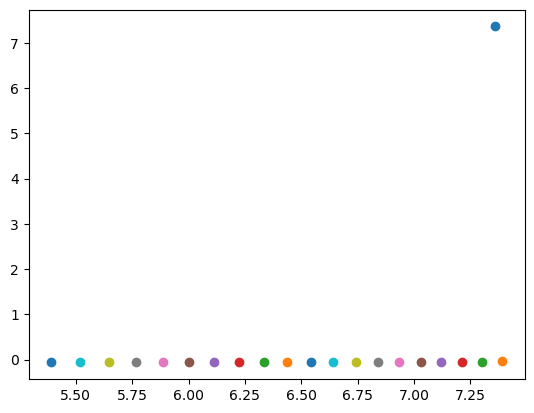

[ 5.26350762 -0.06792271]


In [16]:
#display for van der pol
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import gymnasium

env = gymnasium.make("VDP-v0")
observation, info = env.reset(seed=24)
s=observation
#bestTree=['*', '*', 'math.tanh', 's0', 6.142, 'math.cos', -9.552]
control_name=bestTree
print(s, len(s), control_name)

#s=np.array([-0.1,-0.1])
x=s[0]
y=s[1]

plt.figure(1)
plt.scatter(x,y)#,'ro')
for i in range(400):
    for j in range(len(s)):
        obs_name='s'+str(j)
        control_name=[s[j].item() if c==obs_name else c for c in control_name]
    K,dummy=evaluate(control_name)
    if K>2:  K=2.0
    elif K<-2:  K=-2.0
    K=np.array([K])
    obs, reward, terminated, truncated, info = env.step(K)
    subtotal+=1.*reward
    s=obs
    x=s[0]
    y=s[1]
    if i % 20 ==0:  
        print(x,y,subtotal, s)
        plt.scatter(x, y)
    if (terminated or truncated):  break
env.close()
plt.show()
print(s)

In [47]:
env = gym.make("InvertedDoublePendulum-v4")
observation, info = env.reset(seed=412)
#####notes on using gymnasium######
#need size of observation space for number of states
#need size of action space for number of MLC equations and limits to cap action
# use list(env.observation_space.shape)[0] for size of obs, action spaces
#use env.action_space.low(high).item() for action space min, max

#use MLC for inverted double pendulum gymnasium per:  https://gymnasium.farama.org/environments/mujoco/inverted_double_pendulum/
#generalize for any observation space size

Ni=2500 #number of individuals
Np=25 #idnvidiuals selected for advancement tournament each round
Ne=5  #best Ne of each forest advanced unchanged
Nn=0.5 #for reseed, precent reseeded each round
Ns=list(env.observation_space.shape)[0] #number of sensors

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=1505 #set max number of iterations

#need to get initial measurements from observation, fortunately already is a numpy array (!)
s=observation
b=0 #dummy initialization of b

#will need to refactor for "online" programming, rather than having all measurments avilable at once

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,7,Ns)
    trial=growTrig(0,2,seed)
    forest.append(seed)

minJ=50000 #set initial "best" cost
k=0 #iteration counter

while (minJ>-4900 and k<maxi):
    #make random starting point each forest generation, but same for each tree per generation
    n=random.randint(0,10000)
    for t in forest:
        #reset the environment for each tree using same enivornment for each tree with each time step
        observation, info = env.reset(seed=n)
        #iterate through a list of trees and store best
        #to determine cost, need K and reward for every timestep, env.step provides
        #make sure reward is reset in case tree is reused
        t.total=0
        s=observation
        #need to take a pass of '500' time steps through environment each tree, each iteration
        #for inverted pendulum need to try on several different seeds becuase getting lucky shots that work for one starting point
        for i in range(500):
            control_name=t.name
            #need to replace each "sensor" value with updated observation
            for j in range(len(s)):
                obs_name='s'+str(j)
                control_name=[s[j].item() if c==obs_name else c for c in control_name]
            K,dummy=evaluate(control_name)
            if K>1:  K=1.0
            elif K<-1:  K=-1.0
            K=np.asarray([K])
            obs, reward, terminated, truncated, info = env.step(K)
            if reward>10:  print(reward, i, n, obs)
            t.total+=-1.*reward#+len(control_name)/4.
            if terminated:  t.total+=10000 #include for inverted pendulum
            s=obs
            if (terminated or truncated):  break
        t.total=t.total#/(i+1)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(i, minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
        env.close()
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
    # next_forest=selection(Ni, Np, forest)
    # for t in next_forest:
    #     if len(t.name)==0: print("selection empty")
    #     if type(t.name)==bool:  print("selection bool")
    #Np individuals will be ranked and the best will advance to replication, mutation, crossover
    # forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    k+=1
    print(k, minJ, bestTree)

print("best:  ",minJ, bestTree, k)


5 9945.46998491864 ['math.sin', '+', 's2', 's2']
5 9945.231125890818 ['math.sin', '*', 's4', 's5']
6 9936.551636596103 ['-', 'math.cos', 's6', '*', 's0', 's10']
8 9917.34612978956 ['*', '*', 's1', 's9', '-', 's8', 'math.cos', 's10']
9 9908.113241958115 ['*', '+', 's6', 's4', '-', 's1', 's5']
10 9898.49390251848 ['+', 'math.sin', 's8', '-', 's6', 's2']
11 9889.517829241428 ['-', '*', 's6', 's2', '-', 's7', 's9']
11 9889.201258848703 ['math.sin', '-', 's6', 's2']
12 9879.53686406179 ['*', 'math.cos', 's2', '+', 's0', 's2']
13 9870.705266605122 ['-', '-', 'math.cos', 'math.sin', '-', 's1', 'math.sin', '+', 's6', 's1', 's7', '+', 's0', 's3']
15 9852.002630602907 ['-', '-', 's8', 's2', 'math.sin', 's8']
19 9815.410707205467 ['+', '-', 's3', 's2', '-', 's1', 's4']
20 9804.814587148254 ['-', 'math.cos', -1.515, '-', 's4', 'math.cos', 'math.sin', 's7']
23 9780.577506113856 ['+', '*', 's3', 's5', '-', '-', 's4', 's7', 'math.cos', 's9']
24 9767.845829433221 ['math.sin', 'math.cos', '-', 's6', 's

KeyboardInterrupt: 

In [39]:
import cv2
env = gym.make("InvertedDoublePendulum-v4", render_mode="rgb_array")
obs, info = env.reset(seed=24)
s=obs
print(s[0].item(), s[1].item(), s[2].item())
for i in range(500):
    control_name=bestTree
    #need to replace each "sensor" value with updated observation
    for j in range(len(s)):
        obs_name='s'+str(j)
        control_name=[s[j].item() if c==obs_name else c for c in control_name]
    K,dummy=evaluate(control_name)
    K=np.asarray([K])
    obs, reward, terminated, truncated, info = env.step(K)
    s=obs
    if i % 10 ==0:    
        print(truncated, i, terminated, reward, s[1].item(), s[2].item(), s[3].item())
    #image = env.render()
    #cv2.imshow("image", image)
    # cv2.waitKey(1)
    if (terminated):  break
print(i)
env.close()

-0.03394623266613693 -0.018963400115101184 0.014947007250124223
False 0 False 9.35971836668833 -0.02146836215393295 0.01564380885502288 0.999769528154578
False 10 False 9.359799903387163 -0.006014114936374378 -0.001255326533626501 0.9999819150472333
False 20 False 9.35973275389556 -0.0045366944250855995 -0.0012266744926409546 0.9999897091488958
False 30 False 9.359469983405184 -0.005565299145126347 0.0009267150884422652 0.9999845136027984
False 40 False 9.359031940657788 -0.0035290586166404213 -0.0004061515802530872 0.9999937728532515
False 50 False 9.358366470911763 -0.003258974583124967 6.637258712662746e-05 0.9999946895282327
False 60 False 9.35744503227342 -0.0026418307183275554 1.7627672300384168e-06 0.9999965103591391
False 70 False 9.356235609268587 -0.002138666154334434 -3.296497668182549e-05 0.9999977130509251
False 80 False 9.354712926589723 -0.0017838383246511717 2.9848814079236763e-06 0.99999840895915
False 90 False 9.352857086190678 -0.0014510148990207353 -1.05334472352626

In [33]:
print(random.sample(range(10000),n_batches))

[923, 4120, 1897, 693, 4178]


In [ ]:
#try GP against 2.3.1 in Duriez/Brunton/Noack
#find match for 201 point plane defined by si=i/10, bi=tanh(1.256*si)+1.2; i=[-100,100]
#J = 1/201 sigma (bi-K(si))**2
#test for two sensors

Ni=500 #number of individuals
Np=3 #idnvidiuals selected for advancement tournament each round
Ne=10  #best Ne of each forest advanced unchanged
Nn=0.3 #for reseed, precent reseeded each round
Ns=2 #number of sensors

Pr=0.1 #probably of replication
Pm=0.3 #probably of mutation
Pc=0.6 #probably of crossover

maxi=50 #set max number of iterations

s0=np.arange(-10,10,0.1)
s1=np.arange(-10,10,0.1)
s=np.array([s0,s1]) #row for each sensor, col for each "timestep"
#s=[i/10 for i in s if i>-200]
#b=[math.tanh(1.256*i)+math.sin(2.0*i) for i in s if i>-20]
b=s0 #dummy initialization of b
for t in range(0,s.shape[1]): #iterate through each sensor, assumes only 1 indp. variable (time)
    b[t]=math.tanh(1.256*s[0,t]*s[1,t])+1.2*math.cos(s[1,t])

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,7,Ns)
    trial=grow(0,2,seed)
    forest.append(seed)

minJ=1000 #set "best" cost
i=0 #iteration counter

while (minJ>10**-6 and i<50):
    for t in forest:
        #determine cost function
        #iterate through a list of trees and store best
        t.total=total_evaluate(b,s,t)
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(minJ, bestTree)
#either "tournament" or reseed random proportion of the forest
#evolution tournament code may need updating
    #uncomment below for reseed random proportion of forest
    forest.sort(key=cost_extract)
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)
    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
#     next_forest=selection(Ni, Np, forest)
#     for t in next_forest:
#         if len(t.name)==0: print("selection empty")
#         if type(t.name)==bool:  print("selection bool")
#     #Np individuals will be ranked and the best will advance to replication, mutation, crossover
#     forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    i+=1
    print(i, minJ, bestTree)

print(minJ, bestTree)


In [ ]:
#Exercise 2-3 in in Duriez Brunton Noack (Lorenz System) ,using scipy.integrate.solve_ivp
#solve da/dt=a+b. s=a. b=K(s), minimize 1/T int(a882+g*b**2 dt)
#will need to implement ODE solver and Cost function

Ni=50 #number of individuals
Np=7 #idnvidiuals selected for advancement tournament each round
Ne=1  #best Ne of each forest advanced unchanged
Nn=0.3 #percent new reseeds for evo_reseed

Pr=0.1 #probably of replication
Pm=0.4 #probably of mutation
Pc=0.5 #probably of crossover

g=1.0 #penalization coefficient for acutation cos-t

maxi=50 #set max number of iterations

def dynamics(t, a, control):
#a is 3x1 array a0, a1, a2
#handle plant dynamics, this needs extensive manual modification for each different plant
#have to change dynamcis, and control calculation
    #catch unstable forcing or system to prevent float overflow; may need to adjust catch values for different systems
    a1,a2,a3=a
    
    if a1>100:  a1=100.
    elif a1<-100:  a1=-100.
    if a2>100:  a2=100.
    elif a2<-100:  a2=-100.
    if a3>100:  a3=100.
    elif a3<-100:  a3=-100.
        
    control=[a1 if c=='s0' else c for c in control]
    control=[a2 if c=='s1' else c for c in control]
    control=[a3 if c=='s2' else c for c in control]
    
    K,dummy=evaluate(control)
    da1=10*(a3-a1)
    da2=a1*(28-a3)-a2
    da3=a1*a2-8/3*a3+K
    return np.array([da1, da2, da3])

s=np.arange(0,10,0.025)
s_span=(0,10)
T=s[len(s)-1]-s[0]
dt=s[1]-s[0]

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,5,1)
    trial=grow(0,2,seed)
    forest.append(seed)

minJ=1000 #set "best" cost
j=0 #iteration counter

while (minJ>10**-4 and j<30):
    for t in forest:
        #determine cost function
        #iterate through a list of trees and store best
        #to determine cost, need a and b for every timestep
        #solve returns a t length array of a values
        #need to evaluate b at each step for dynamics and cost function
        #probably should use evaluate function on its own and avoid total_evaluate
        control_name=t.name
        b=[]
        result=solve_ivp(dynamics, s_span, np.array([1.0, 1.0, 1.0]), t_eval=s, args=[control_name])
        #result.y=np.reshape(result.y, (result.y.size,))
        for i in range(len(s)):
            control_name=t.name
            control_name=[result.y[0,i] if c=='s0' else c for c in control_name]
            control_name=[result.y[1,i] if c=='s1' else c for c in control_name]
            control_name=[result.y[2,i] if c=='s2' else c for c in control_name]
            K,dummy=evaluate(control_name)
            b.append(K)
        t.total=1/T*sum(dt*(np.array(result.y[0,:])**2+np.array(result.y[1,:])**2+np.array(result.y[2,:])**2+g*np.array(b)**2))
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
#     next_forest=selection(Ni, Np, forest)
#     for t in next_forest:
#         if len(t.name)==0: print("selection empty")
#         if type(t.name)==bool:  print("selection bool")
#     #Np individuals will be ranked and the best will advance to replication, mutation, crossover
#     forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    j+=1
    print(j, minJ, bestTree)

print(minJ, bestTree)

In [25]:
print(range(5))

range(0, 5)


In [ ]:
#Exercise 3-2 in in Duriez Brunton Noack (Lorenz System) ,using scipy.integrate.solve_ivp
#should probably remove transcendental functions, at least trig ones

Ni=50 #number of individuals
Np=7 #idnvidiuals selected for advancement tournament each round
Ne=1  #best Ne of each forest advanced unchanged
Nn=0.3 #percent new reseeds for evo_reseed
Ns=2

Pr=0.1 #probably of replication
Pm=0.4 #probably of mutation
Pc=0.5 #probably of crossover

g=1.0 #penalization coefficient for acutation cos-t

maxi=50 #set max number of iterations

def dynamics(t, a, control):
#a is 3x1 array a0, a1, a2
#handle plant dynamics, this needs extensive manual modification for each different plant
#have to change dynamcis, and control calculation
    #catch unstable forcing or system to prevent float overflow; may need to adjust catch values for different systems
    a1,a2=a
    
    if a1>100:  a1=100.
    elif a1<-100:  a1=-100.
    if a2>100:  a2=100.
    elif a2<-100:  a2=-100.
        
    control=[a1 if c=='s0' else c for c in control]
    control=[a2 if c=='s1' else c for c in control]
    
    K,dummy=evaluate(control)
    da1=-1*a1+a2
    da2=a2+K
    return np.array([da1, da2])

s=np.arange(0,10,0.025)
s_span=(0,10)
T=s[len(s)-1]-s[0]
dt=s[1]-s[0]

forest=[]
#generate forest of Ni trees
for i in range(0,Ni):
    seed=sapling(2,5,Ns)
    trial=grow(0,2,seed)
    forest.append(seed)

minJ=1000 #set "best" cost
j=0 #iteration counter

while (minJ>10**-4 and j<30):
    for t in forest:
        #determine cost function
        #iterate through a list of trees and store best
        #to determine cost, need a and b for every timestep
        #solve returns a t length array of a values
        #need to evaluate b at each step for dynamics and cost function
        #probably should use evaluate function on its own and avoid total_evaluate
        control_name=t.name
        b=[]
        result=solve_ivp(dynamics, s_span, np.array([1.0, 1.0]), t_eval=s, args=[control_name])
        #result.y=np.reshape(result.y, (result.y.size,))
        for i in range(len(s)):
            control_name=t.name
            control_name=[result.y[0,i] if c=='s0' else c for c in control_name]
            control_name=[result.y[1,i] if c=='s1' else c for c in control_name]
            K,dummy=evaluate(control_name)
            b.append(K)
        t.total=1/T*sum(dt*(np.array(result.y[0,:])**2+np.array(result.y[1,:])**2+g*np.array(b)**2))
        if t.total<minJ: 
            minJ=t.total
            bestTree=t.name
            print(minJ, bestTree)
#either "tournament" or reseed random half of the forest
    #uncomment below for reseed random half of forest
    forest=evolution_reseed(Nn, Ni, Ne,Pc, Pm, forest)

    #uncomment below for tournament approach
    #need to choose Np individuals for each selection round. 
#     next_forest=selection(Ni, Np, forest)
#     for t in next_forest:
#         if len(t.name)==0: print("selection empty")
#         if type(t.name)==bool:  print("selection bool")
#     #Np individuals will be ranked and the best will advance to replication, mutation, crossover
#     forest=evolution(Ne, Pc, Pm, next_forest)
    # for i in range(0, Ni):
    #     print(forest[i].name)
    j+=1
    print(j, minJ, bestTree)

print(minJ, bestTree)

In [ ]:
print(control_name)

In [ ]:
1.9069441847077115 ['+', '*', '+', '-', 'math.sin', 5.212, 's0', '*', 'math.sin', -5.23, '+', 's1', 's1', 8.922, '+', 7.89, 'math.log', '+', '+', '-', 'math.sin', 'math.tanh', -8.567, 's0', '*', '-', 's1', '*', 'math.sin', 's1', 'math.cos', 's0', '+', 's0', '+', '*', '+', '-', 'math.sin', 5.212, '+', 's1', 's1', '*', '+', 's1', '-', 's1', 's0', '+', 's1', 'math.tanh', '*', '+', '*', 'math.log', '-', 's1', '+', 's1', '-', '*', 's1', '-', 'math.sin', 5.212, '+', 's1', 's1', 's0', 'math.log', 'math.exp', -8.663, 'math.cos', 'math.log', '+', '+', '-', 'math.sin', 'math.tanh', -8.567, 's0', '*', '-', 's1', '*', 'math.sin', 's1', 'math.cos', 's0', '+', 's0', '+', '*', '+', '-', 'math.sin', 5.212, '+', 's1', 's1', '*', '+', 's1', '-', 's1', 's0', '+', 's1', 'math.tanh', '*', '+', '*', 'math.log', 'math.sin', 's0', 'math.log', 'math.exp', -8.663, 'math.cos', 's1', 'math.sin', '+', 'math.tanh', 'math.log', 's1', 's0', 8.922, '+', 7.89, 'math.log', '+', 'math.cos', '+', 'math.exp', 'math.cos', '-', 's1', -2.137, 'math.cos', 's1', 's0', '*', '-', 's1', '+', 's1', '-', 's1', 's0', '+', 's0', '+', '*', '+', '-', 'math.sin', 5.212, 's0', '*', 'math.sin', -5.23, '+', 's1', 's1', 8.922, '+', 7.89, 'math.log', '+', '-', 'math.sin', 's0', 's0', '*', 's1', '+', 'math.log', 'math.cos', 'math.log', 'math.tanh', 'math.tanh', 's0', 's1', 'math.sin', '+', 'math.tanh', 'math.log', 's1', 's0', 8.922, '+', 7.89, 'math.log', '+', 'math.cos', '+', 'math.exp', 'math.cos', '-', 's1', -2.137, 'math.cos', 's1', '*', 'math.tanh', 's1', '+', 'math.log', 'math.cos', '+', '*', '+', '-', 0.041, 's0', 's1', 8.922, 's0', 's1', '*', '-', 's1', '+', 's1', '-', 's1', 's0', '+', 's0', '+', '*', '+', '-', 'math.sin', 5.212, 's0', '*', 'math.sin', -5.23, '+', 's1', 's1', 8.922, '+', 7.89, 'math.log', '+', '-', 'math.sin', 's0', 's0', '*', 's1', '+', 'math.log', 'math.cos', 'math.log', 'math.tanh', 's0', 's1']